In [55]:
# auto-load when code changes outside
%load_ext autoreload
%autoreload 2
%load_ext pyinstrument

import sys
sys.path.insert(0,'..')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The pyinstrument extension is already loaded. To reload it, use:
  %reload_ext pyinstrument


In [56]:
#imports 
import os
import nltk
import spacy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.onnx as onnx
import torch.optim as optim
import torchvision.models as models

from src.baseline.vocabulary import Vocabulary
from src.utils import print_time, list_of_tensors_to_numpy_arr, plot_image, plot_im
from src.accuracy import Accuracy
from src.baseline.coa_model import get_new_model,load_model, train_validate_test_split, init_testing_model, test_model, test_rand_image


In [57]:
!export CUDA_VISIBLE_DEVICES=0
!export CUDA_LAUNCH_BLOCKING=1

In [58]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

device

device(type='cpu')

In [59]:
# torch.cuda.get_device_name(0)

In [60]:
# Hyperparams

embed_size=300
vocab_size = 36
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4
drop_prob=0.3
ignored_idx = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

hyper_params = {'embed_size': embed_size,
                'attention_dim': attention_dim,
                'encoder_dim': encoder_dim,
                'decoder_dim': decoder_dim,
                'vocab_size': vocab_size
              }


# Test the loaded model on synthetic data

In [65]:
# data_location = '/home/space/datasets/COA/generated-data-api'
# data_location =  '/home/space/datasets/COA/generated-data-api-small'
# data_location =  '/home/space/datasets/COA/generated-data-api-large'

data_location =  '../baseline-gen-data/large'
root_folder_images = data_location + '/images'

test_caption_file = data_location + '/test_captions_psumsq.txt'
df = pd.read_csv(test_caption_file)

print("There are {} test images".format(len(df)))

There are 400 test images


In [66]:
# model_path = '../models/baseline/attention_model-qsub-06.05.2022-18:19:28.pth'
model_path = '../models/baseline/attention_model-qsub-06.05.2022-20:12:44.pth'
model, optimizer, loss,criterion = load_model(model_path, 
                                    hyper_params, 
                                    learning_rate,
                                    drop_prob, 
                                    ignored_idx)

In [67]:
!export CUDA_LAUNCH_BLOCKING=1
!export CUDA_VISIBLE_DEVICES=2

In [68]:
# BATCH_SIZE = 5
NUM_WORKER = 2 #### this needs multi-core
freq_threshold = 5
batch_size = 256

# 30 minutes to create those, as it's baseline, i ran it several times and it's the same
vocab = Vocabulary(freq_threshold)
vocab.stoi = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'lion': 4, 'rampant': 5, 'passt': 6, 'guard': 7, 'head': 8, 'lions': 9, 'cross': 10, 'moline': 11, 'patonce': 12, 'eagle': 13, 'doubleheaded': 14, 'eagles': 15, 'a': 16, 'b': 17, 'o': 18, 's': 19, 'g': 20, 'e': 21, 'v': 22, '1': 23, '2': 24, '3': 25, '4': 26, '5': 27, '6': 28, '7': 29, '8': 30, '9': 31, '10': 32, '11': 33, 'border': 34, '&': 35}
vocab.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'lion', 5: 'rampant', 6: 'passt', 7: 'guard', 8: 'head', 9: 'lions', 10: 'cross', 11: 'moline', 12: 'patonce', 13: 'eagle', 14: 'doubleheaded', 15: 'eagles', 16: 'a', 17: 'b', 18: 'o', 19: 's', 20: 'g', 21: 'e', 22: 'v', 23: '1', 24: '2', 25: '3', 26: '4', 27: '5', 28: '6', 29: '7', 30: '8', 31: '9', 32: '10', 33: '11', 34: 'border', 35: '&'}


In [69]:
test_loader, test_dataset = init_testing_model(test_caption_file, 
                                               root_folder_images, 
                                               NUM_WORKER,
                                               vocab,
                                               batch_size, 
                                               device, 
                                               pin_memory=False)


mean, std: tensor(0.2875) tensor(0.3448)


In [71]:
test_losses, accuracy_test_list, acc_test_score, test_loss = test_model(model, 
                                                                        criterion,
                                                                        test_loader, 
                                                                        test_dataset, 
                                                                        vocab_size, 
                                                                        device)

b b lion & border
Test Acuuracy (in progress): 0.500000

b s lion
Test Acuuracy (in progress): 0.500000

Test Loss (final): 0.024504

Test Accuracy (Overall): 50.0%


## Visualizing the attentions

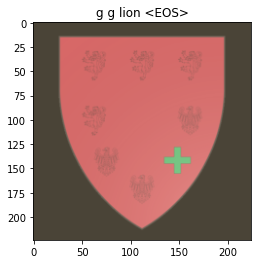

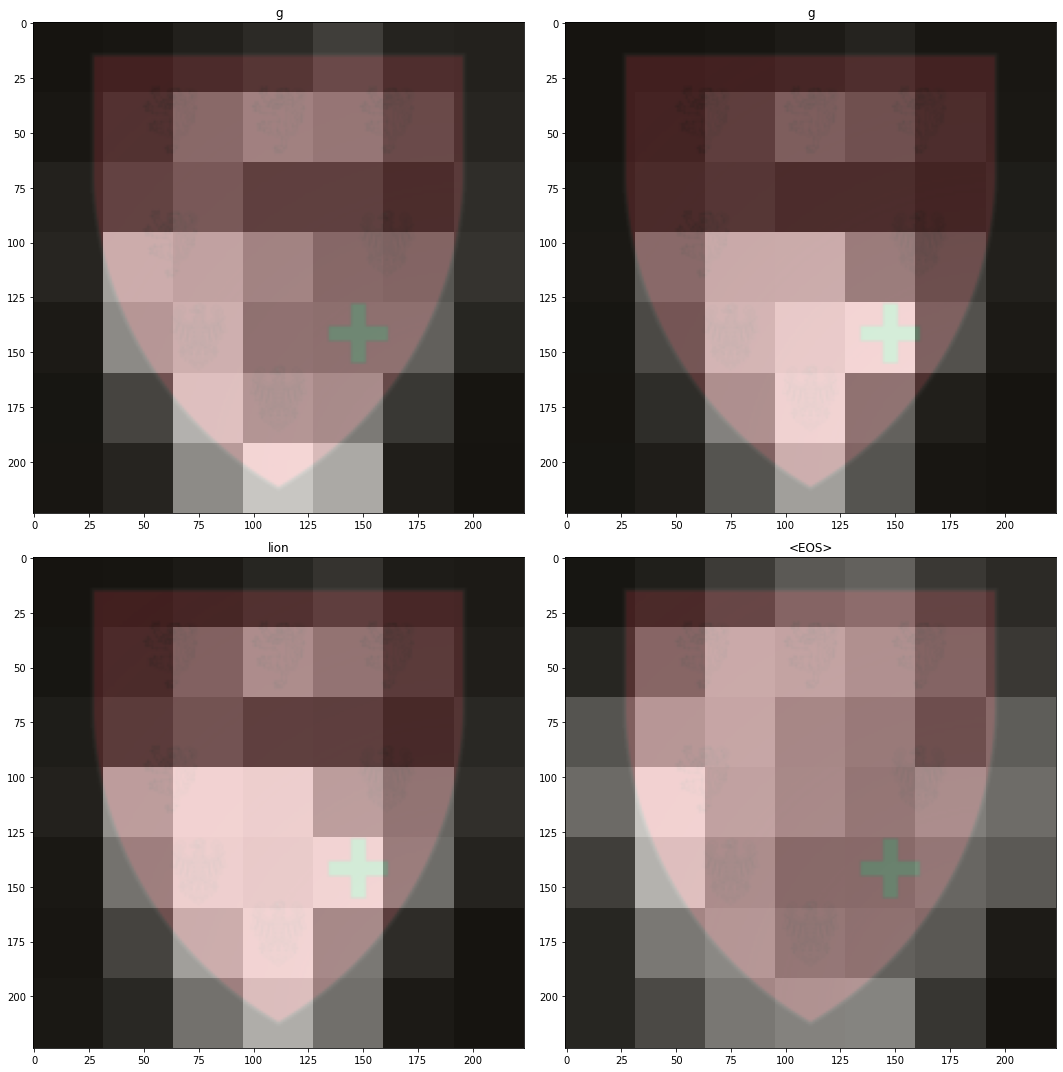

In [72]:
# torch.cuda.empty_cache()
test_rand_image(model,test_dataset,test_loader,device)

# Test the loaded model on real data


In [73]:
# data_location='/home/salnabulsi/coat-of-arms/data/cropped_coas/out_valid'
# data_location='/home/salnabulsi/coat-of-arms/data/cropped_coas/out'
# data_location='/Users/salnabulsi/tub/coat-of-arms/data/cropped_coas/out_valid'

data_location='/Users/salnabulsi/tub/coat-of-arms/data/cropped_coas/out'
test_caption_file  = data_location + '/test_real_captions_psumsq.txt'
root_folder_images = data_location + '/images/resized'

df = pd.read_csv(test_caption_file)

print("There are {} test images".format(len(df)))

df

There are 269 test images


,image,caption,psum,psum_sq
0,1739_A G cross patonce.jpg,A G cross patonce,724933.00000,557413.50000
1,22117_O B cross patriarchal.jpg,O B cross patriarchal,696633.87500,521719.93750
2,2870_O S lion rampant.jpg,O S lion rampant,370219.71875,231043.09375
3,6870_S O eagle.jpg,S O eagle,840800.62500,661782.93750
4,18746_S A eagle.jpg,S A eagle,880971.43750,601956.43750
...,...,...,...,...
264,398_A S lion rampant.jpg,A S lion rampant,673480.62500,517651.34375
265,249_O G 2 lions passt.jpg,O G 2 lions passt,871046.06250,677358.06250
266,4459_B O eagle.jpg,B O eagle,621500.62500,425808.43750
267,5302_O B cross moline.jpg,O B cross moline,736149.62500,530970.68750


## Get the model

In [74]:
model, optimizer, criterion = get_new_model(hyper_params, 
                                            learning_rate, 
                                            ignored_idx, 
                                            drop_prob,
                                            device)


In [75]:
!export CUDA_LAUNCH_BLOCKING=1
!export CUDA_VISIBLE_DEVICES=2


In [76]:

# BATCH_SIZE = 5
NUM_WORKER = 2 #### this needs multi-core
freq_threshold = 5
batch_size = 256

# 30 minutes to create those, as it's baseline, i ran it several times and it's the same
vocab = Vocabulary(freq_threshold)
vocab.stoi = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'lion': 4, 'rampant': 5, 'passt': 6, 'guard': 7, 'head': 8, 'lions': 9, 'cross': 10, 'moline': 11, 'patonce': 12, 'eagle': 13, 'doubleheaded': 14, 'eagles': 15, 'a': 16, 'b': 17, 'o': 18, 's': 19, 'g': 20, 'e': 21, 'v': 22, '1': 23, '2': 24, '3': 25, '4': 26, '5': 27, '6': 28, '7': 29, '8': 30, '9': 31, '10': 32, '11': 33, 'border': 34, '&': 35}
vocab.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'lion', 5: 'rampant', 6: 'passt', 7: 'guard', 8: 'head', 9: 'lions', 10: 'cross', 11: 'moline', 12: 'patonce', 13: 'eagle', 14: 'doubleheaded', 15: 'eagles', 16: 'a', 17: 'b', 18: 'o', 19: 's', 20: 'g', 21: 'e', 22: 'v', 23: '1', 24: '2', 25: '3', 26: '4', 27: '5', 28: '6', 29: '7', 30: '8', 31: '9', 32: '10', 33: '11', 34: 'border', 35: '&'}


In [79]:
test_loader, test_dataset = init_testing_model(test_caption_file, 
                                               root_folder_images, 
                                               NUM_WORKER,
                                               vocab,
                                               batch_size,
                                               device, 
                                               pin_memory=False 
                                               ,img_h=600, img_w=620)

# avg size resized (600, 620)


mean, std: tensor(0.6768) tensor(0.1706)


In [80]:

test_model(model, criterion,test_loader, test_dataset, vocab_size, device)


11 <SOS> doubleheaded lions 4 lions 4 lions 4 lions 4 lions e <SOS> lions v <SOS> doubleheaded lions
label "11 <SOS> doubleheaded lions 4 lions 4 lions 4 lions 4 lions e <SOS> lions v <SOS> doubleheaded lions" cannot be parsed. The chunk "<SOS>" cannot be fit into any category.
label "11 <SOS> doubleheaded lions 4 lions 4 lions 4 lions 4 lions e <SOS> lions v <SOS> doubleheaded lions" cannot be parsed. The chunk "<SOS>" cannot be fit into any category.
label "11 <SOS> doubleheaded lions 4 lions 4 lions 4 lions 4 lions e <SOS> lions v <SOS> doubleheaded lions" cannot be parsed. The chunk "<SOS>" cannot be fit into any category.
Test Acuuracy (in progress): 0.000000

9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
No shield color found in this label: "9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9"
Test Acuuracy (in progress): 0.000000

Test Loss (final): 0.026849

Test Accuracy (Overall): 0.0%


([tensor(3.6233), tensor(3.5991)], [0.0, 0.0], 0.0, tensor(0.0268))

## Visualizing the attentions


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


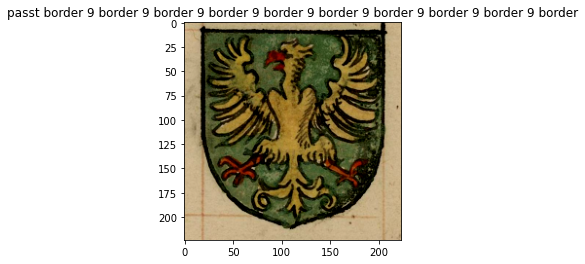

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

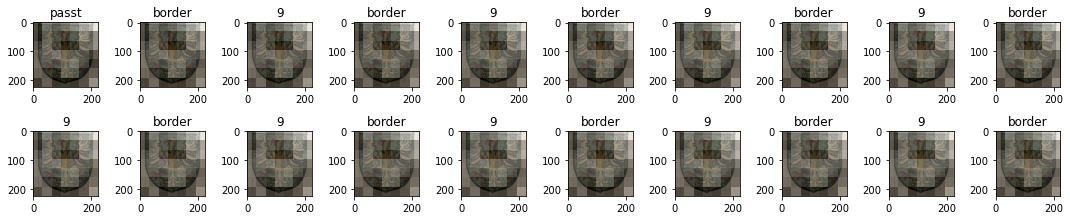

In [83]:
# torch.cuda.empty_cache()
test_rand_image(model,test_dataset,test_loader,device)
